# score based model(NCSN)に基づく生成モデル

In [10]:
import numpy as np
import torch
import torch.distributions as distributions
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [11]:
def plot_density(dist):
    """2次元確率密度関数を可視化する関数

    Args:
        dist : 可視化したい確率密度関数
    """
    ls = np.linspace(-7, 7, 1000)
    x, y = np.meshgrid(ls, ls)
    xy_grid = np.stack([x, y], axis=2)
    grid_tensor = torch.from_numpy(xy_grid).float()

    probs = torch.exp(dist.log_prob(grid_tensor)).numpy()

    fig, ax = plt.subplots(figsize=(9, 6))

    c = ax.pcolormesh(x, y, probs.reshape(x.shape))
    fig.colorbar(c, ax=ax, label="Density")

    ax.set_title("Density of Mixture Normal Distribution")
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_aspect("equal", adjustable="box")

    plt.show()

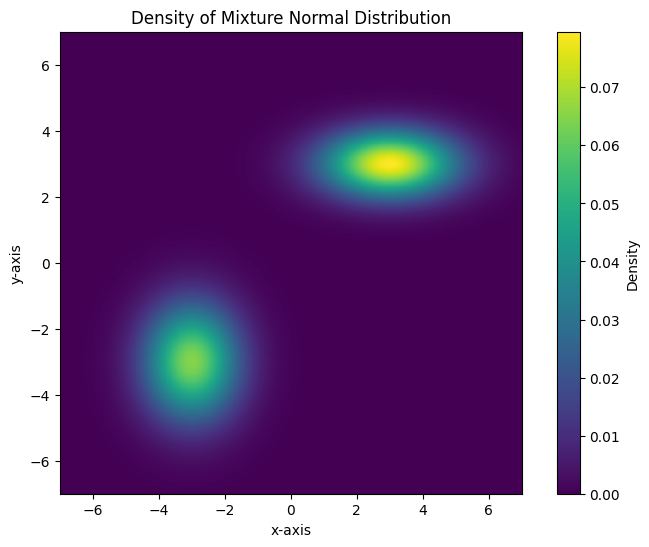

In [12]:
means = torch.tensor([[3.0, 3.0], [-3.0, -3.0]])

cov_mats = torch.Tensor([
    [[ 2.0,  0.0],
     [ 0.0,  0.5]],
    [[ 1.0,  0.0],
     [ 0.0,  1.5]],
])

mixture_weights = torch.tensor([0.5, 0.5])

mixture_dist = distributions.MixtureSameFamily(
    distributions.Categorical(mixture_weights),
    distributions.MultivariateNormal(means, cov_mats)
)

plot_density(mixture_dist)

In [13]:
def train(model, dist, device, num_epoch, batch_size, test_size, sigma_scale):
    """モデルを学習する関数

    Args:
        model : 学習したいモデル
        dist : 学習したい確率分布
        device : 学習に用いる計算資源("cpu" or "CUDA")
        num_epoch : 学習するエポック数
        batch_size : 1エポックの学習に用いるデータ数
        test_size : 1回のテストに用いるデータ数
        sigma_scale :学習時に用いる分散の最大値 

    Returns:
        _type_: _description_
    """
    sigma_test = torch.tensor(1.0).to(device)
    sigma_batch_test = sigma_test.expand(test_size, 1)
    loss_list = []
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    

    for epoch in tqdm(range(num_epoch)):
        model.train()
        optimizer.zero_grad()
        
        samples = dist.sample((batch_size,)).to(device)

        sigma = (sigma_scale * torch.rand(1)).to(device)
        noises = torch.randn_like(samples) * sigma

        samples_tilde = samples + noises

        sigma_batch = sigma.expand(batch_size, 1)
        input_vector = torch.concat([samples_tilde, sigma_batch], axis=1)

        pred_y = model(input_vector)
        target_y = - noises / sigma**2

        loss = (sigma**2 * (torch.linalg.norm(pred_y - target_y, dim=1).mean())).squeeze()

        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            model.eval()

            samples_test = dist.sample((test_size,)).to(device)
            noises_test = torch.randn_like(samples_test) * sigma_test
            samples_tilde_test = samples_test + noises_test

            input_vector_test = torch.concat([samples_tilde_test, sigma_batch_test], axis=1)
            pred_y_test = model(input_vector_test)
            target_y_test = - noises_test / sigma_test**2

            loss_test = (sigma_test**2 * (torch.linalg.norm(pred_y_test - target_y_test).mean())).squeeze()

            loss_list.append([epoch, loss_test.item()])

    return loss_list


In [14]:
input_dim = 2
mid1_dim = 12
mid2_dim = 48
mid3_dim = 48
mid4_dim = 12
output_dim = input_dim

model = nn.Sequential(
    nn.Linear(input_dim + 1, mid1_dim),# input_dimはベクトルの次元であり、ネットワークはそれに加えてノイズの強さをインプットに入れる
    nn.ReLU(),
    nn.Linear(mid1_dim, mid2_dim),
    nn.ReLU(),
    nn.Linear(mid2_dim, mid3_dim),
    nn.ReLU(),
    nn.Linear(mid3_dim, mid4_dim),
    nn.ReLU(),
    nn.Linear(mid4_dim, output_dim)
).to(device)

num_epoch = 100000
batch_size = 2000
test_size = 100
sigma_scale = 5.0

loss_list = train(model, mixture_dist, device, num_epoch, batch_size, test_size, sigma_scale)

100%|██████████| 100000/100000 [10:47<00:00, 154.42it/s]


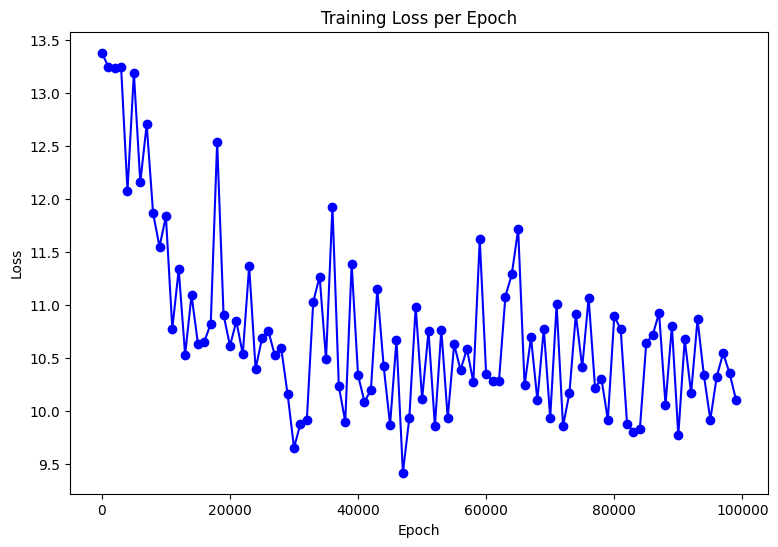

In [15]:
epochs = [item[0] for item in loss_list]
losses = [item[1] for item in loss_list]

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(epochs, losses, marker='o', linestyle='-', color='b')
ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.show()

In [16]:
@torch.no_grad()
def sampling_ncsn(model, sigma_max, sigma_min, step_scale, num_sigma, num_samples, num_steps):
    """学習したモデルを用いてデータを生成する関数

    Args:
        model : データを生成するモデル
        sigma_max : サンプリング時に用いる分散の最大値
        sigma_min (_type_): サンプリング時に用いる分散の最小値
        step_scale (_type_): サンプリング時の1ステップのスケール
        num_sigma (_type_): サンプリングに用いる分散の個数
        num_samples (_type_): サンプリングするデータの個数
        num_steps (_type_): 1つのノイズスケールにおけるステップ数

    Returns:
        _type_: _description_
    """
    input_dim = 2
    samples = torch.randn(num_samples, input_dim).to(device)

    sigma_list = torch.tensor(np.geomspace(start=sigma_max, stop=sigma_min, num=num_sigma), dtype=torch.float32).to(device)

    model.eval()

    for i, sigma in tqdm(enumerate(sigma_list)):
        step_scale_i = step_scale * (sigma ** 2) / (sigma_max ** 2)
        sigma_batch = sigma.expand(num_samples, 1)

        for k in range(num_steps):
            noises = torch.randn_like(samples)
            if i == num_sigma - 1 and k == num_steps - 1:
                noises = torch.zeros_like(samples).to(device)
            
            input_vector = torch.concat([samples, sigma_batch], axis=1)
            samples = samples + step_scale_i / 2.0 * model(input_vector) + torch.sqrt(step_scale_i) * noises
    
    return samples.to("cpu").numpy()

In [17]:
def plot_sampling(samples):
    fig, ax = plt.subplots(figsize=(9, 6))

    _, _, _, c = ax.hist2d(samples[:, 0], samples[:, 1], range=((-7, 7), (-7, 7)), bins=100)
    fig.colorbar(c, ax=ax, label="Frequency")

    ax.set_title("Sampling with Score Funtion")
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_aspect("equal", adjustable="box")

    plt.show()

50it [08:28, 10.17s/it]


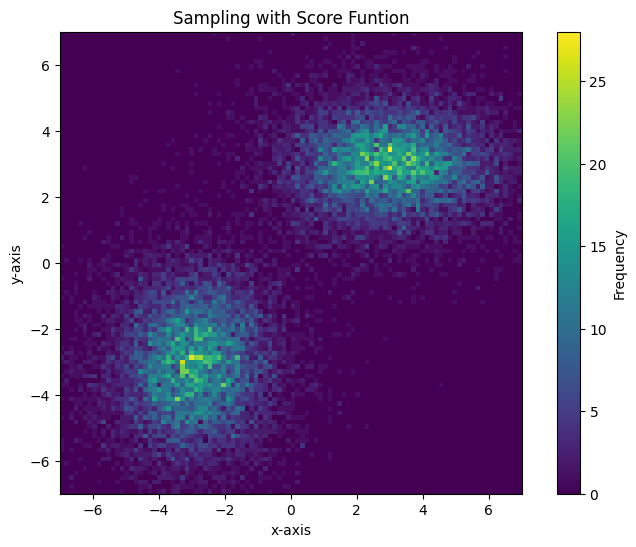

In [18]:
sigma_max = 10
sigma_min = 0.01
step_scale = 0.1
num_sigma = 50
num_samples = 20000
num_steps = 1000

samples = sampling_ncsn(model, sigma_max, sigma_min, step_scale, num_sigma, num_samples, num_steps)

plot_sampling(samples)